In [69]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
sys.path.append('../../code/gwas_analysis')
from gwas_plotting import manhattan, manhattan_fixwidth, qqplot
from gwas_utils import annotate_gwas_plink2
from IPython.display import display
import glob
from scipy.stats import chi2, ranksums

# Dylan said this will let us edit in illustrator, we shall see!
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [4]:
psamfn = 'gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220113.INFO_8e-1.chr1.psam'
psam = pd.read_csv(psamfn, sep='\t')
psam.index = psam['#IID']
psam.head()

,#IID,SEX,Batch
#IID,,,
WG0284565-DNA_A02_G-5231,WG0284565-DNA_A02_G-5231,2,1
WG0284565-DNA_A03_G-5686,WG0284565-DNA_A03_G-5686,2,1
WG0284565-DNA_A04_G-5690,WG0284565-DNA_A04_G-5690,1,1
WG0284565-DNA_A05_G-5135,WG0284565-DNA_A05_G-5135,2,1
WG0284565-DNA_A06_G-5045,WG0284565-DNA_A06_G-5045,2,1


In [5]:
sample_matching = pd.read_csv('gs://popgen-gwas/data/metadata/Annotated_GenotypedData/preANDpost2016_Merged_Complete_Metadata_WithAge_20210818.tsv', sep='\t')
sample_matching.index = sample_matching['Full_IID']
sample_matching = sample_matching.loc[psam.index, :]
sample_matching.head()

,Full_IID,Genotype_Sex,ID_Reformat,SampleType,sex,Disease,ISTH_SandR_Key,KGH_Survivor_Key,KGH_AcuteLassa_Key,KGH_AcuteEbola_Key,...,Batch,Country,Sex_Discrepant,Sex_Discrepant_Notes,Status,Clean_HLA_ID,Epoch,Array,CollectionEpoch,Age
#IID,,,,,,,,,,,,,,,,,,,,,
WG0284565-DNA_A02_G-5231,WG0284565-DNA_A02_G-5231,F,G-5231,SuspectedEbolaSL,F,Ebola,NaN,S-056,NaN,G-5231,...,1,SL,False,NaN,Passes QC,NaN,Post2016,H3,Post2016,38.0
WG0284565-DNA_A03_G-5686,WG0284565-DNA_A03_G-5686,F,G-5686,SuspectedEbolaSL,F,Ebola,NaN,NaN,NaN,G-5686,...,1,SL,False,NaN,Passes QC,NaN,Post2016,H3,Post2016,10.0
WG0284565-DNA_A04_G-5690,WG0284565-DNA_A04_G-5690,M,G-5690,SuspectedEbolaSL,M,Ebola,NaN,S-158,NaN,G-5690,...,1,SL,False,NaN,Passes QC,S-158,Post2016,H3,Post2016,16.0
WG0284565-DNA_A05_G-5135,WG0284565-DNA_A05_G-5135,F,G-5135,SuspectedEbolaSL,F,Ebola,NaN,S-006,NaN,G-5135,...,1,SL,False,NaN,Passes QC,S-006,Post2016,H3,Post2016,49.0
WG0284565-DNA_A06_G-5045,WG0284565-DNA_A06_G-5045,F,G-5045,SuspectedEbolaSL,F,Ebola,NaN,NaN,NaN,G-5045,...,1,SL,False,NaN,Passes QC,NaN,Post2016,H3,Post2016,24.0


In [15]:
# each row is a genotyped sample, named by its IID. this table contains metadata we can use for phenotype definition
# and stratification
group_fn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups = pd.read_csv(group_fn, sep='\t')
groups.index = groups['#IID']
groups.head()

,#IID,SEX,Batch,SampleType,Disease,Epoch,Epoch_Bin,Country,Age,CollectionEpoch,...,Post2016_SL_LASV_AgPos_DC,Post2016_SL_LASV_AgPos_Died,Pre2016_SL_LASV_qPCR1xPos,Pre2016_SL_LASV_SeqPos,Pre2016_SL_LASV_AgPos,Pre2016_SL_LASV_AgORSeqPos,Pre2016_SL_LASV_PopControl,Pre2016_SL_LASV_IgPosPopControl,Pre2016_SL_LASV_AgORSeqPos_DC,Pre2016_SL_LASV_AgORSeqPos_Died
#IID,,,,,,,,,,,,,,,,,,,,,
WG0284565-DNA_A02_G-5231,WG0284565-DNA_A02_G-5231,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,38.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
WG0284565-DNA_A03_G-5686,WG0284565-DNA_A03_G-5686,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,10.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
WG0284565-DNA_A04_G-5690,WG0284565-DNA_A04_G-5690,1,1,SuspectedEbolaSL,Ebola,Post2016,1,1,16.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
WG0284565-DNA_A05_G-5135,WG0284565-DNA_A05_G-5135,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,49.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
WG0284565-DNA_A06_G-5045,WG0284565-DNA_A06_G-5045,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,24.0,Post2016,...,False,False,False,False,False,False,False,False,False,False


In [16]:
diagpre2016 = pd.read_csv('gs://popgen-gwas/data/metadata/PopgenPre2016/Test_Metadata/jul2015_merged_cases_controls_diagnostic_data_qpcrUpdate_updated20190901.txt', sep='\t')
diagpre2016.index = diagpre2016['IID']

diag_ind = sample_matching['Full_IID'].isin(psam.index) & ~sample_matching['Pre2016_Diagnostic_Key'].isnull()
diag_ids = sample_matching.loc[diag_ind, 'Pre2016_Diagnostic_Key']

diagpre2016_overlap = diagpre2016.loc[diag_ids, :]

diagpre2016_overlap['Full_ID'] = sample_matching.loc[diag_ind, 'Full_IID'].values
diagpre2016_overlap.index = diagpre2016_overlap['Full_ID']

diagpre2016_overlap = diagpre2016_overlap.loc[diagpre2016_overlap.index.isin(groups['#IID']), :]

diagpre2016_overlap.head()

,FID,IID,PID,MID,SEX,PHE,SITE,Age,IgG,IgM,...,Ag,IGG,qPCR,clinical,LASV_copies,18S_copies,LASV_Ct,RCID,GID,Full_ID
Full_ID,,,,,,,,,,,,,,,,,,,,,
WG0284582-DNA_A02_F-SL-71C,F-SL-71,F-SL-71C,0,0,2,1,SL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A02_F-SL-71C
WG0284582-DNA_A05_SM-87W5V,F-NG-NC-113,F-NG-NC-113M,0,0,2,1,NG,38.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A05_SM-87W5V
WG0284582-DNA_A06_SM-NEIDU,F-NG-C-94,F-NG-C-94C,0,0,2,1,NG,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A06_SM-NEIDU
WG0284582-DNA_A07_C-0183,C-0183,SM-299Q3,0,0,2,1,SL,60.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A07_C-0183
WG0284582-DNA_A09_C-0307,C-0307,SM-299QJ,0,0,1,1,SL,11.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A09_C-0307


In [17]:
groups = groups.loc[diagpre2016_overlap.index, :]

In [50]:
diagpre2016_overlap['Group'] = np.nan
ng_controls = ['Pre2016_NG_LASV_PopControl', 'Post2016_NG_LASV_PopControl']
for c in ng_controls:
    diagpre2016_overlap.loc[groups[c], 'Group'] = 'NG'
    
sl_controls = ['Pre2016_SL_LASV_PopControl']
for c in sl_controls:
    diagpre2016_overlap.loc[groups[c], 'Group'] = 'SL'

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [51]:
diagpre2016_overlap = diagpre2016_overlap.loc[~diagpre2016_overlap['Group'].isnull(), :]

In [52]:
diagpre2016_overlap.head()

,FID,IID,PID,MID,SEX,PHE,SITE,Age,IgG,IgM,...,IGG,qPCR,clinical,LASV_copies,18S_copies,LASV_Ct,RCID,GID,Full_ID,Group
Full_ID,,,,,,,,,,,,,,,,,,,,,
WG0284582-DNA_A02_F-SL-71C,F-SL-71,F-SL-71C,0,0,2,1,SL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A02_F-SL-71C,SL
WG0284582-DNA_A05_SM-87W5V,F-NG-NC-113,F-NG-NC-113M,0,0,2,1,NG,38.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A05_SM-87W5V,NG
WG0284582-DNA_A06_SM-NEIDU,F-NG-C-94,F-NG-C-94C,0,0,2,1,NG,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A06_SM-NEIDU,NG
WG0284582-DNA_A07_C-0183,C-0183,SM-299Q3,0,0,2,1,SL,60.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A07_C-0183,SL
WG0284582-DNA_A09_C-0307,C-0307,SM-299QJ,0,0,1,1,SL,11.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A09_C-0307,SL


In [53]:
ind = ~diagpre2016_overlap['IgG'].isnull() & ~diagpre2016_overlap['Age'].isnull()
diagpre2016_overlap_forplot = diagpre2016_overlap.loc[ind, :]

In [54]:
diagpre2016_overlap_forplot['Seropositive'] = diagpre2016_overlap_forplot['IgG']>0

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
ct = pd.crosstab(diagpre2016_overlap_forplot['Seropositive'], diagpre2016_overlap_forplot['Group'])
ct

Group,NG,SL
Seropositive,,
False,540,296
True,211,293


In [56]:
ct.div(ct.sum(axis=0), axis=1)

Group,NG,SL
Seropositive,,
False,0.719041,0.502547
True,0.280959,0.497453


In [99]:
cut_bins = [0, 20, 40, 60, 100]
diagpre2016_overlap_forplot['Age_Bin'] = pd.cut(diagpre2016_overlap_forplot['Age'], bins=cut_bins, right=False)
diagpre2016_overlap_forplot['Seropositive_100'] = diagpre2016_overlap_forplot['Seropositive'].replace({True:100, False:0})
diagpre2016_overlap_forplot.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,FID,IID,PID,MID,SEX,PHE,SITE,Age,IgG,IgM,...,LASV_copies,18S_copies,LASV_Ct,RCID,GID,Full_ID,Group,Seropositive,Age_Bin,Seropositive_100
Full_ID,,,,,,,,,,,,,,,,,,,,,
WG0284582-DNA_A05_SM-87W5V,F-NG-NC-113,F-NG-NC-113M,0,0,2,1,NG,38.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A05_SM-87W5V,NG,True,"[20, 40)",100
WG0284582-DNA_A07_C-0183,C-0183,SM-299Q3,0,0,2,1,SL,60.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A07_C-0183,SL,True,"[60, 100)",100
WG0284582-DNA_A09_C-0307,C-0307,SM-299QJ,0,0,1,1,SL,11.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A09_C-0307,SL,False,"[0, 20)",0
WG0284582-DNA_A10_C-0173,C-0173,SM-299PT,0,0,2,1,SL,60.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A10_C-0173,SL,False,"[60, 100)",0
WG0284582-DNA_A11_SM-5X7Q1,F-NG-NC-192,F-NG-NC-192M,0,0,2,1,NG,40.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,WG0284582-DNA_A11_SM-5X7Q1,NG,True,"[40, 60)",100


In [100]:
diagpre2016_overlap_forplot['Group'].value_counts()

NG    751
SL    589
Name: Group, dtype: int64

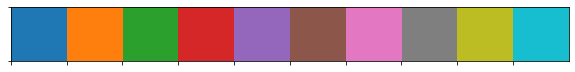

In [104]:
sns.palplot(sns.color_palette())


In [123]:
colors = [sns.color_palette(desat=1).as_hex()[5], sns.color_palette().as_hex()[4]]
colors = ['#264653', '#E9C46A']
colors = ['#b47eb3', '#8bb8a8']

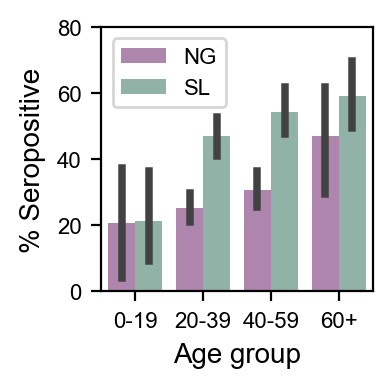

In [127]:
(fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=200)
sns.barplot(x='Age_Bin', y='Seropositive_100', hue='Group', data=diagpre2016_overlap_forplot, ax=ax, palette=colors)
ax.set_xlabel('Age group')
ax.set_ylabel('% Seropositive')
ax.set_xticklabels(['0-19', '20-39', '40-59', '60+'], fontsize=8)
ax.set_yticklabels([0, 20, 40, 60, 80], fontsize=8)
ax.set_ylim([0,80])
ax.legend(fontsize=8)
#ax.set_title('Seroprevalence by age')
plt.savefig('../../figures/SeroprevalenceByAge.pdf', bbox_inches='tight')
plt.savefig('../../figures/SeroprevalenceByAge.png', bbox_inches='tight')

In [93]:
ng_ind = diagpre2016_overlap_forplot['Group']=='NG'
sl_ind = diagpre2016_overlap_forplot['Group']=='SL'
seropos_ind = diagpre2016_overlap_forplot['Seropositive']

print(ranksums(diagpre2016_overlap_forplot.loc[ng_ind & seropos_ind, 'Age'], diagpre2016_overlap_forplot.loc[ng_ind & ~seropos_ind, 'Age']))
diagpre2016_overlap_forplot.loc[ng_ind & seropos_ind, 'Age'].median(), diagpre2016_overlap_forplot.loc[ng_ind & ~seropos_ind, 'Age'].median()

RanksumsResult(statistic=3.3001852158490963, pvalue=0.0009662103855996227)


(38.0, 36.0)

In [94]:
print(ranksums(diagpre2016_overlap_forplot.loc[sl_ind & seropos_ind, 'Age'], diagpre2016_overlap_forplot.loc[sl_ind & ~seropos_ind, 'Age']))
diagpre2016_overlap_forplot.loc[sl_ind & seropos_ind, 'Age'].median(), diagpre2016_overlap_forplot.loc[sl_ind & ~seropos_ind, 'Age'].median()

RanksumsResult(statistic=3.6818826461878533, pvalue=0.00023151798177213048)


(40.0, 35.0)